<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_1_image_generator_no_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the code below to download the compressed dataset `horse-or-human.zip`.

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2024-04-06 11:50:47--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   182MB/s    in 0.8s    

2024-04-06 11:50:48 (182 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



You can then unzip the archive using the [zipfile](https://docs.python.org/3/library/zipfile.html) module.

In [2]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

In [3]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

To see what the filenames look like in the `horses` and `humans` training directories:

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse17-9.png', 'horse18-8.png', 'horse39-9.png', 'horse38-9.png', 'horse10-6.png', 'horse28-2.png', 'horse15-0.png', 'horse33-0.png', 'horse48-6.png', 'horse19-1.png']
['human05-04.png', 'human10-27.png', 'human04-15.png', 'human10-19.png', 'human13-09.png', 'human03-11.png', 'human14-14.png', 'human14-27.png', 'human10-03.png', 'human15-00.png']


You can also find out the total number of horse and human images in the directories:

In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

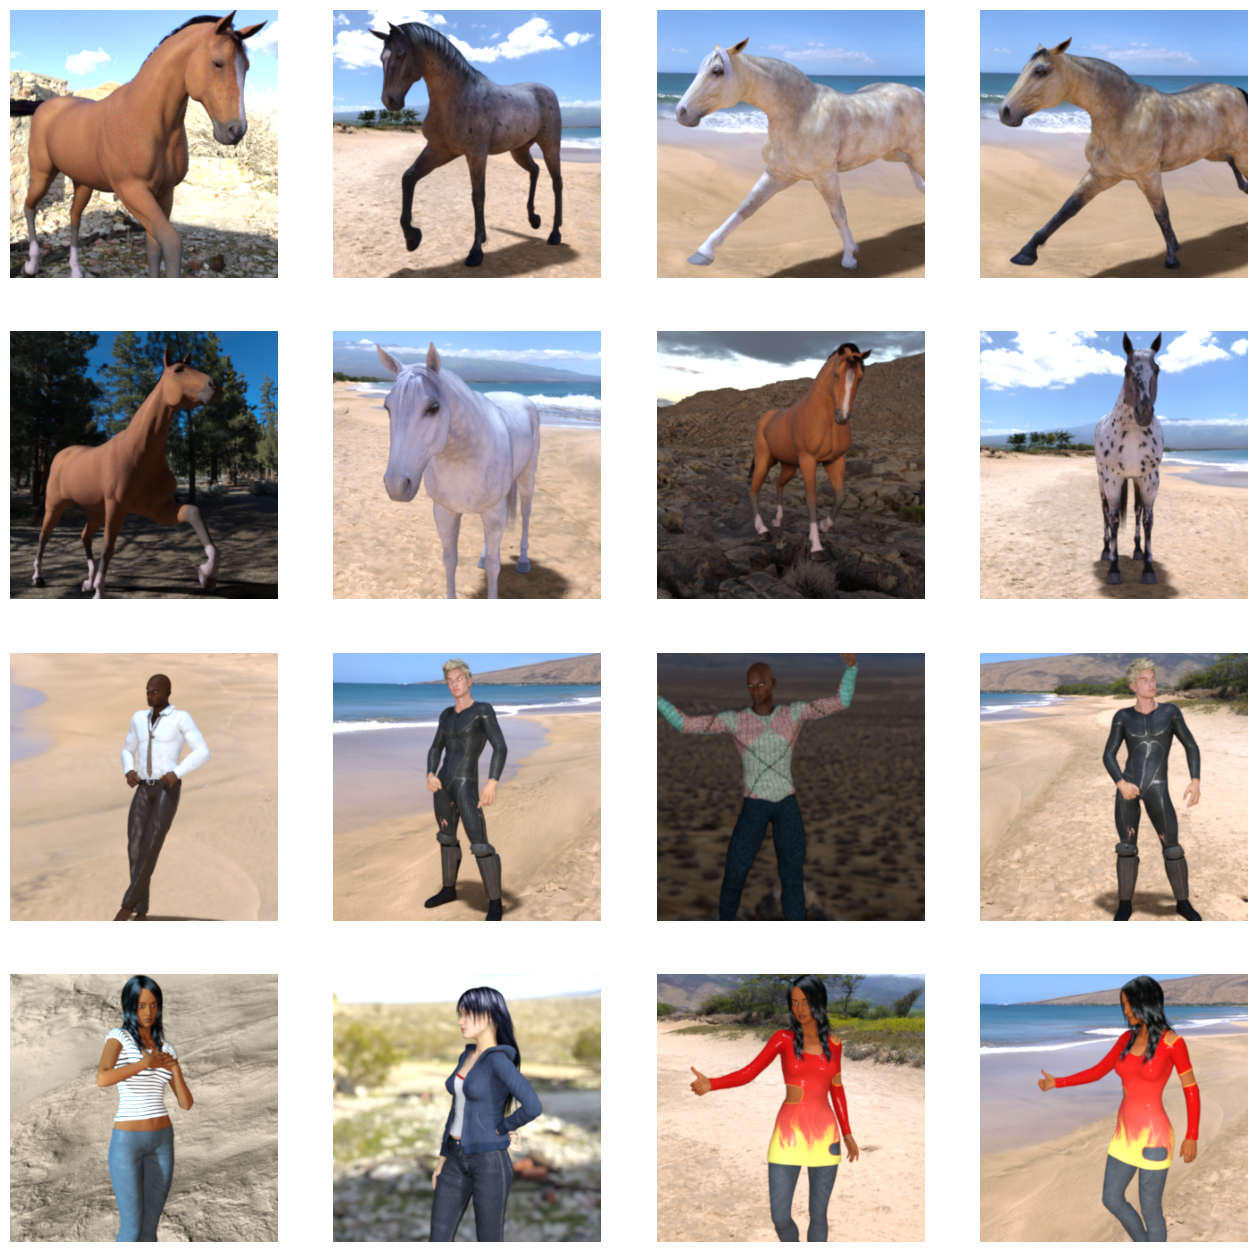

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

Now you can define the model architecture that you will train.

Step 1 will be to import tensorflow.

In [9]:
import tensorflow as tf

In [11]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can review the network architecture and the output shapes with `model.summary()`.

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 35, 35, 64)       

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Training


In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 16s 633ms/step - loss: 3.1987 - accuracy: 0.5873
Epoch 2/15
8/8 [==============================] - 8s 958ms/step - loss: 0.6353 - accuracy: 0.5406
Epoch 3/15
8/8 [==============================] - 7s 896ms/step - loss: 0.6656 - accuracy: 0.7314
Epoch 4/15
8/8 [==============================] - 8s 1s/step - loss: 0.6672 - accuracy: 0.7720
Epoch 5/15
8/8 [==============================] - 7s 866ms/step - loss: 0.3496 - accuracy: 0.9344
Epoch 6/15
8/8 [==============================] - 8s 981ms/step - loss: 0.4307 - accuracy: 0.8231
Epoch 7/15
8/8 [==============================] - 7s 775ms/step - loss: 0.5062 - accuracy: 0.8565
Epoch 8/15
8/8 [==============================] - 6s 769ms/step - loss: 0.1903 - accuracy: 0.9244
Epoch 9/15
8/8 [==============================] - 7s 889ms/step - loss: 0.0985 - accuracy: 0.9668
Epoch 10/15
8/8 [==============================] - 7s 849ms/step - loss: 0.0604 - accuracy: 0.9766
Epoch 11/15
8/8 [====

### Model Prediction


In [16]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving horse.jpg to horse.jpg
1/1 [==============================] - 0s 340ms/step
[0.00018443]
horse.jpg is a horse


### Visualizing Intermediate Representations



1/1 [==============================] - 0s 76ms/step


<ipython-input-17-6a20c666c98b>:45: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-17-6a20c666c98b>:48: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


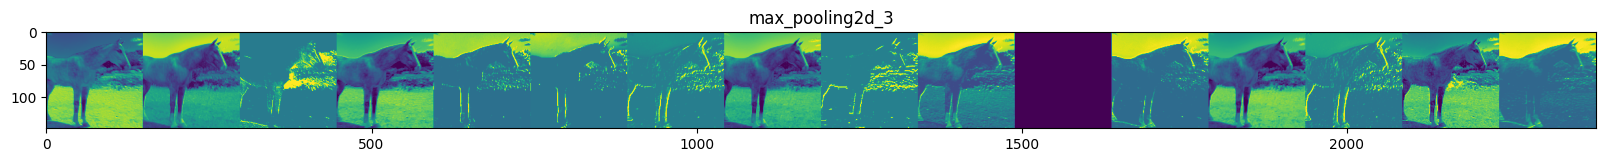

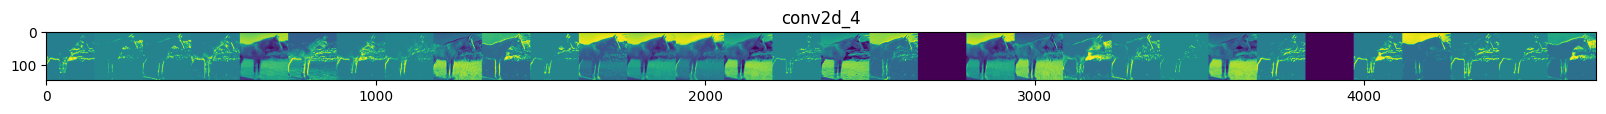

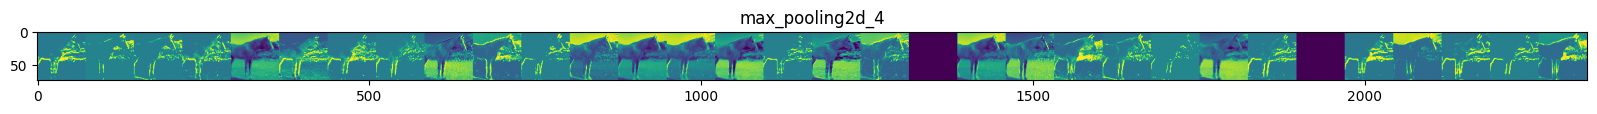

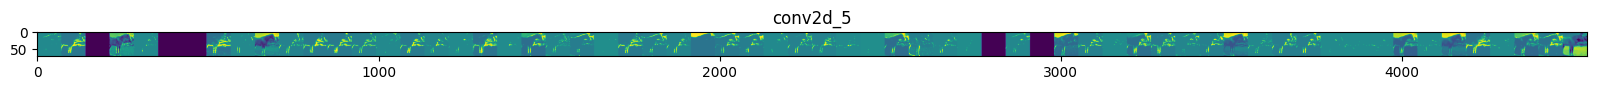

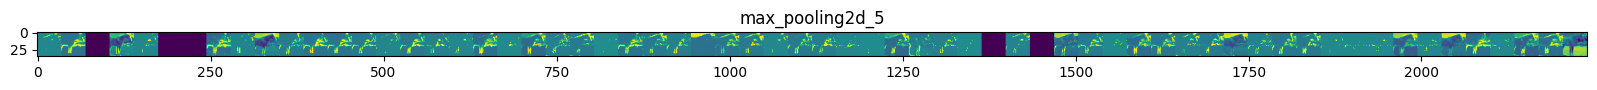

In [17]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')